In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from scipy import io as sio
import random
from sklearn.neighbors import NearestNeighbors
%matplotlib inline 

In [2]:
# Mask dense
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias = True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)


In [24]:
# MADE architecture
class MADEnet(nn.Module):
    def __init__(self, nin, hidden_sizes, nout, ordering, num_masks):
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.hidden_sizes = hidden_sizes
        assert self.nout % self.nin  == 0
        
        self.net = []
        hs = [nin] + hidden_sizes + [nout]
        for h0, h1 in zip(hs, hs[1:]):
            self.net.extend([
                MaskedLinear(h0, h1),
                nn.ReLU()])
        self.net.pop()
        self.net = nn.Sequential(*self.net)
        
        self.num_masks = num_masks
        self.seed = 16
        
        self.m = {}
        self.m[-1] = ordering
         
        self.direct = MaskedLinear(self.nin, self.nout)
        mask_direct = self.m[-1][:,None] < self.m[-1][None,:]
        mask_direct = np.array(mask_direct)
        print(mask_direct)
        self.direct.set_mask(mask_direct)

        self.update_masks()
        
    def update_masks(self):
        if len(self.m) != 1 and self.num_masks == 1: 
          return
        L = len(self.hidden_sizes)
        
        # 1 seed -> 1 mask =>> update seed
        rng = np.random.RandomState(self.seed)
        self.seed = (self.seed + 1) % self.num_masks
        
        # random m in hidden layers
        for l in range(L):
            self.m[l] = rng.randint(self.m[l-1].min(), self.nin - 1, size = self.hidden_sizes[l])
        
        # construct masks
        masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(L)]
        masks.append(self.m[L-1][:,None] < self.m[-1][None, :])
        
        # use for other output distributions 
        if self.nout > self.nin:
            k = int(self.nout / self.nin)
            masks[-1] = np.concatenate([masks[-1]]*k, axis = 1)
            
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l, m in zip(layers,  masks):
            l.set_mask(m)

  
    
    def forward(self, x):
        return self.net(x)
        #return self.net(x) + self.direct(x)

In [25]:
class MADE():
  def __init__(self, hiddens='500', num_masks=1, ordering='raster-scan', 
               samples=1, resample_every=20, data='mnist', imgshape = (28,28)):
    # tunning params
    self.hiddens = hiddens
    self.num_masks = num_masks
    self.ordering = ordering 
    self.samples = samples
    self.resample_every = resample_every
    self.data_path_mnist = '/content/drive/My Drive/datasets/binarized_mnist.npz'
    self.data_path_emnist = '/content/drive/My Drive/datasets/emnist-letters.mat'
    self.data_path_shape = '/content/drive/My Drive/datasets/shapes/data.npy'
    self.imgshape = imgshape
    np.random.seed(16)
    torch.manual_seed(16)
    torch.cuda.manual_seed_all(16)

    # loading data
    print("Loading data ...")
    if data =='emnist':
      print("Dataset EMNIST")
      self.load_data_emnist()
    elif data =='mnist':
      print("Dataset MNIST")
      self.load_data_mnist()
    elif data =='shape':
      print("Dataset SHAPE")
      self.load_data_shape()
    print("Loading data done")
    print("------------------------------")

    # Construct mode and ship to GPU
    print("Constructing MADE architecture ...")
    
    hidden_list = list(map(int, self.hiddens.split(',')))
    
      #create order
    if self.ordering == 'raster-scan':
      self.order = np.arange(self.xtr.size(1))
    elif self.ordering =='columns':
      a = np.arange(0, self.xtr.size(1)).reshape(self.imgshape)
      x = a.T
      self.order = x.reshape(self.xtr.size(1))
    elif self.ordering == 'randoms':
      self.order = np.random.RandomState(16).permutation(self.xtr.size(1))
    elif self.ordering == 'reverseRS':
      self.order = np.arange(self.xtr.size(1))[::-1]
    elif self.ordering == 'top_down_mid':
      l = self.xtr.size(1)
      top = np.arange(self.xtr.size(1))
      down = top[l//2:][::-1]
      self.order = np.concatenate([top[:l//2], down])

    self.model = MADEnet(nin = self.xtr.size(1), hidden_sizes=hidden_list, 
                         nout=self.xtr.size(1), ordering=self.order, num_masks=self.num_masks)
    self.model.cuda()
    
      #set up the optimizer
    self.opt = torch.optim.Adam(self.model.parameters(), 1e-3, weight_decay=1e-4)
    self.scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=45, gamma=0.1)
    print("Constructing MADE architecture done")
    print("------------------------------")
   
  def reconstruct(self, n):
    rng = np.random.randint(low = 0, high = self.xtr.size(0), size = n, dtype=int)
    l = self.xtr.size(1)
    origin = [self.xtr[i].tolist() for i in rng]
    origin = np.array(origin).astype(np.float32)
    deconstruct = origin
    deconstruct[:,l//2:] = 0
    x  = torch.from_numpy(deconstruct).cuda()
    with torch.no_grad():
      for i in range(l//2 + 1, l, 1):
        logits = self.model(x)[:,i].cuda()
        probs = torch.sigmoid(logits).cuda()
        x[:,i] = torch.bernoulli(probs)
      x = x.view(n, self.xtr.size(1))

    return origin, np.array(x.tolist()).astype(np.float32) 
    

  def sample(self, n, resample = True):
    noise = torch.rand(n, self.xtr.size(1)).cuda()
    samples = self.samples if resample else 1
    with torch.no_grad():
        for i in self.order:
            logits = torch.zeros(n).cuda()
            # resampling
            for s in range(samples):
               logits += self.model(noise)[:, i]
            logits = logits / samples
            probs = torch.sigmoid(logits)
            noise[:, i] = torch.bernoulli(probs)
        noise = noise.view(n, self.xtr.size(1))
    return np.array(noise.tolist()).astype(np.int32)
  
  def get_nearest_real_images(self, xfake):
    # Kneighbor algo for comparing
    self.nrnb = NearestNeighbors(n_neighbors= 1, p=2)
    self.nrnb.fit(self.xtr.tolist())
    indices = self.nrnb.kneighbors(xfake, return_distance=False)
    tmp = self.xtr.tolist()
    xnearest = [tmp[i[0]] for i in indices]
    xnearest = np.array(xnearest).astype(np.int32)
    return xnearest

  def gen_fake_and_save(self, filename, resample):
    xfake = self.sample(100, resample= resample)
    fig=plt.figure(figsize=(8, 8))
    columns = 10
    rows = 10
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(xfake[i-1].reshape(self.imgshape), cmap ='gray')
    #plt.savefig(filename)
    plt.show()

  def training(self, epochs, batch_size):
      path = "/content/drive/My Drive/datasets/MADE_skip/"
      self.batch_size = batch_size
      self.test_loss = []
      self.train_loss = []
      print("Start training")
      for epoch in range(epochs):
          print("Epoch %d" % (epoch, ))
          self.scheduler.step(epoch)
          te_loss = self.run_epoch('test', upto= 5)
          tr_loss = self.run_epoch('train')
          self.test_loss.append(te_loss)
          self.train_loss.append(tr_loss)
          if epoch % 10 == 0 or epoch + 1 == epochs:
            filename = "epoch"+str(epoch)+".png";
            self.gen_fake_and_save(path+filename, False)
      print("Training done")
  
  def load_data_shape(self):
    X = np.load(self.data_path_shape)
    indices = np.arange(0, X.shape[0])
    random.shuffle(indices)
    X = X[indices].astype(np.float32)
    l = 1600
    xtr, xte = X[indices[:l]], X[indices[l:]]
                 
    self.xtr = torch.from_numpy(xtr).cuda()
    self.xte = torch.from_numpy(xte).cuda()

  def load_data_mnist(self):
    mnist = np.load(self.data_path_mnist)
    self.xtr, self.xte = mnist['train_data'], mnist['valid_data']
    self.xtr = torch.from_numpy(self.xtr).cuda()
    self.xte = torch.from_numpy(self.xte).cuda()
  def load_data_emnist(self):
    mat = sio.loadmat(self.data_path_emnist)
    data = mat['dataset']
    X_train = data['train'][0,0]['images'][0,0]
    X_test = data['test'][0,0]['images'][0,0]
    X_train = X_train.reshape(X_train.shape[0], 28, 28, order="F")
    X_test = X_test.reshape(X_test.shape[0], 28, 28 , order="F")
    X_train = X_train.reshape(X_train.shape[0], 784, order='C').astype(np.float32)
    X_test = X_test.reshape(X_test.shape[0], 784, order='C').astype(np.float32)
    X_train = np.round(X_train / 255.)
    X_test = np.round(X_test/ 255.)
    self.xtr = torch.from_numpy(X_train).cuda()
    self.xte = torch.from_numpy(X_test).cuda()

  def run_epoch(self, split, upto = None):
    torch.set_grad_enabled(split == 'train')
    if split == 'train': self.model.train()
    else: self.model.eval()
    
    x = self.xtr if split == 'train' else self.xte
    samples = 1 if split == 'train' else self.samples
    N,D = x.size()
    B = self.batch_size
    nsteps = N//B if upto is None else min(N//B, upto)
    lossfs = []
    # An epoch has many batches
    for step in range(nsteps):
        # Get next batch data shape [B, D]
        xb = Variable(x[step*B:step*B+B])
        # A batch is fed through net many times (nsamples)
        # Calculate mean of xbhat
        xbhat = torch.zeros_like(xb)
        for s in range(samples):
            # perform order/connectivity-agnostic training by resampling the masks
            if step % self.resample_every == 0 or split == 'test': # if in test, cycle masks every time
                self.model.update_masks()
            # forward the model
            xbhat += self.model(xb)
        xbhat /= samples
        

        # Evaluate the binary cross entropy loss
        loss = F.binary_cross_entropy_with_logits(xbhat, xb, size_average=False) / B
        lossf = loss.data.item()
        lossfs.append(lossf)
  
        # backward/update
        if split == 'train':
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()

    mean_loss = np.mean(lossfs) 
    print("%s epoch loss: %f" % (split, mean_loss))
    return mean_loss

  def draw_epoch_loss(self):
    plt.plot(self.train_loss, label='train')
    plt.plot(self.test_loss, label='test')
    plt.legend(loc='best')
    plt.show()
      



In [26]:
made = MADE(hiddens = '800,800', num_masks = 5, data = 'mnist', ordering='raster-scan',samples = 10, resample_every=40, imgshape=(28,28))

Loading data ...
Dataset MNIST
Loading data done
------------------------------
Constructing MADE architecture ...
[[False  True  True ...  True  True  True]
 [False False  True ...  True  True  True]
 [False False False ...  True  True  True]
 ...
 [False False False ... False  True  True]
 [False False False ... False False  True]
 [False False False ... False False False]]
Constructing MADE architecture done
------------------------------


Start training
Epoch 0


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

test epoch loss: 543.753625
train epoch loss: 236.780866


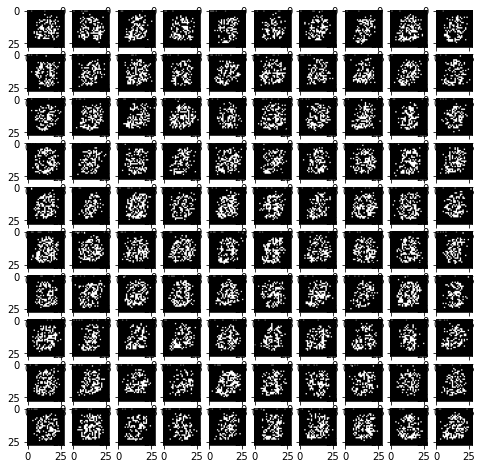

Epoch 1
test epoch loss: 182.438055
train epoch loss: 170.851270
Epoch 2
test epoch loss: 160.711719
train epoch loss: 154.197482
Epoch 3
test epoch loss: 146.773056
train epoch loss: 142.833172
Epoch 4
test epoch loss: 136.618375
train epoch loss: 134.832238
Epoch 5
test epoch loss: 131.110492
train epoch loss: 129.780571
Epoch 6
test epoch loss: 125.354132
train epoch loss: 125.320590
Epoch 7
test epoch loss: 122.412494
train epoch loss: 122.518433
Epoch 8
test epoch loss: 119.203851
train epoch loss: 120.230291
Epoch 9
test epoch loss: 116.963763
train epoch loss: 118.317953
Epoch 10
test epoch loss: 115.360353
train epoch loss: 117.077535


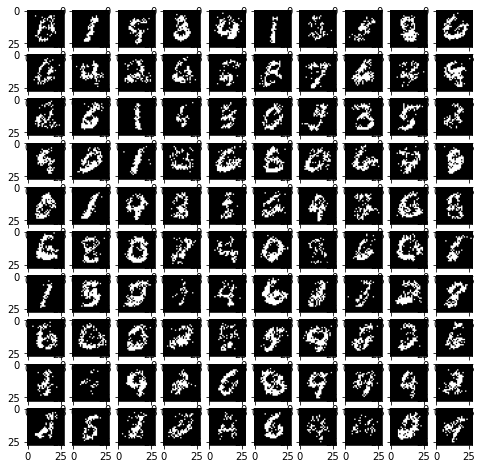

Epoch 11
test epoch loss: 114.155922
train epoch loss: 115.543738
Epoch 12
test epoch loss: 113.012692
train epoch loss: 114.655254
Epoch 13
test epoch loss: 111.293495
train epoch loss: 113.664517
Epoch 14
test epoch loss: 111.227316
train epoch loss: 112.828982
Epoch 15
test epoch loss: 109.627232
train epoch loss: 112.336918
Epoch 16
test epoch loss: 109.395306
train epoch loss: 111.404925
Epoch 17
test epoch loss: 108.772507
train epoch loss: 110.957087
Epoch 18
test epoch loss: 107.913553
train epoch loss: 110.434882
Epoch 19
test epoch loss: 108.055353
train epoch loss: 109.903658
Epoch 20
test epoch loss: 106.943137
train epoch loss: 109.521775


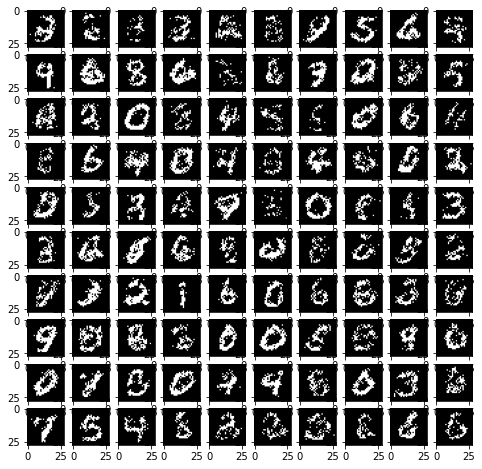

Epoch 21
test epoch loss: 106.756674
train epoch loss: 108.995146
Epoch 22
test epoch loss: 106.445647
train epoch loss: 108.752478
Epoch 23
test epoch loss: 105.949103
train epoch loss: 108.400839
Epoch 24
test epoch loss: 106.026062
train epoch loss: 107.980174
Epoch 25
test epoch loss: 105.241483
train epoch loss: 107.741719
Epoch 26
test epoch loss: 105.059047
train epoch loss: 107.390550
Epoch 27
test epoch loss: 104.943748
train epoch loss: 107.217396
Epoch 28
test epoch loss: 104.564630
train epoch loss: 106.971986
Epoch 29
test epoch loss: 104.582637
train epoch loss: 106.631965
Epoch 30
test epoch loss: 104.149315
train epoch loss: 106.494467


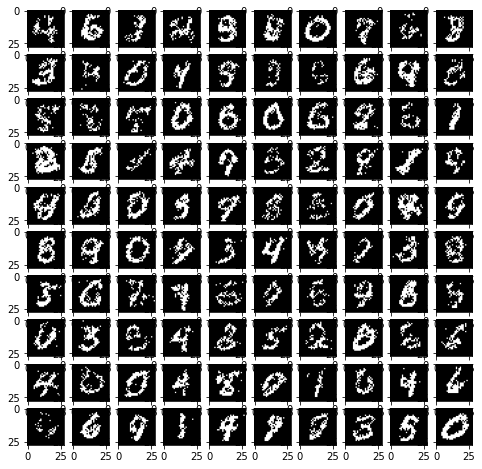

Epoch 31
test epoch loss: 103.938634
train epoch loss: 106.247699
Epoch 32
test epoch loss: 103.854045
train epoch loss: 106.083366
Epoch 33
test epoch loss: 103.621727
train epoch loss: 105.934347
Epoch 34
test epoch loss: 103.651601
train epoch loss: 105.661311
Epoch 35
test epoch loss: 103.327959
train epoch loss: 105.557425
Epoch 36
test epoch loss: 103.227609
train epoch loss: 105.368137
Epoch 37
test epoch loss: 103.009111
train epoch loss: 105.229422
Epoch 38
test epoch loss: 102.900385
train epoch loss: 105.166625
Epoch 39
test epoch loss: 103.012767
train epoch loss: 104.902455
Epoch 40
test epoch loss: 102.680838
train epoch loss: 104.852800


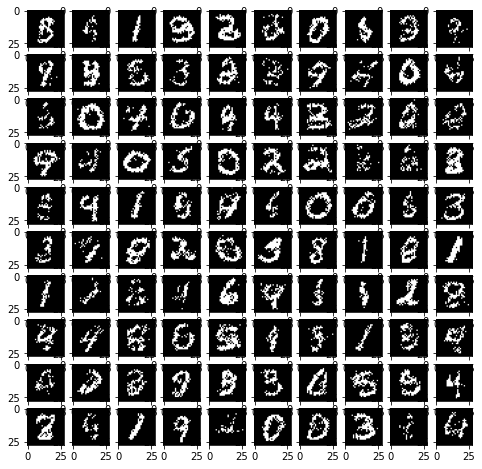

Epoch 41
test epoch loss: 102.582581
train epoch loss: 104.686584
Epoch 42
test epoch loss: 102.479523
train epoch loss: 104.574690
Epoch 43
test epoch loss: 102.391701
train epoch loss: 104.520775
Epoch 44
test epoch loss: 102.425363
train epoch loss: 104.314072
Epoch 45
test epoch loss: 102.203786
train epoch loss: 103.230488
Epoch 46
test epoch loss: 100.078625
train epoch loss: 101.792836
Epoch 47
test epoch loss: 99.970178
train epoch loss: 101.309442
Epoch 48
test epoch loss: 99.881314
train epoch loss: 100.776977
Epoch 49
test epoch loss: 99.869931
train epoch loss: 99.961245
Epoch 50
test epoch loss: 99.838350
train epoch loss: 101.595434


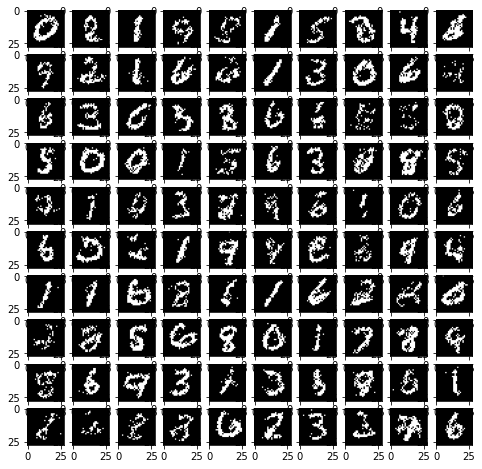

Epoch 51
test epoch loss: 99.774115
train epoch loss: 101.212616
Epoch 52
test epoch loss: 99.751672
train epoch loss: 100.920805
Epoch 53
test epoch loss: 99.707854
train epoch loss: 100.538877
Epoch 54
test epoch loss: 99.718059
train epoch loss: 99.968211
Epoch 55
test epoch loss: 99.699716
train epoch loss: 101.299466
Epoch 56
test epoch loss: 99.647859
train epoch loss: 100.957343
Epoch 57
test epoch loss: 99.632216
train epoch loss: 100.721237
Epoch 58
test epoch loss: 99.601329
train epoch loss: 100.408259
Epoch 59
test epoch loss: 99.617516
train epoch loss: 99.949150
Epoch 60
test epoch loss: 99.603107
train epoch loss: 101.093472


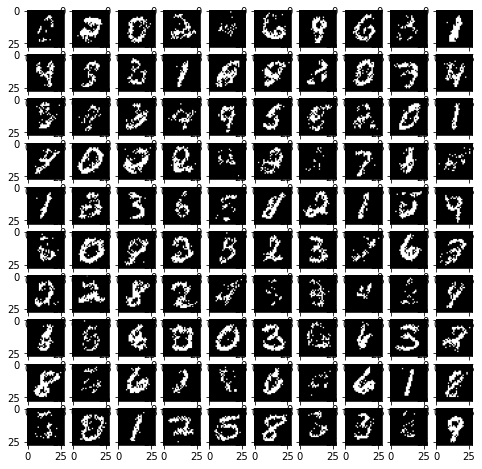

Epoch 61
test epoch loss: 99.553389
train epoch loss: 100.778400
Epoch 62
test epoch loss: 99.542496
train epoch loss: 100.576573
Epoch 63
test epoch loss: 99.519043
train epoch loss: 100.307369
Epoch 64
test epoch loss: 99.533974
train epoch loss: 99.914086
Epoch 65
test epoch loss: 99.521371
train epoch loss: 100.929582
Epoch 66
test epoch loss: 99.472794
train epoch loss: 100.634941
Epoch 67
test epoch loss: 99.464377
train epoch loss: 100.457989
Epoch 68
test epoch loss: 99.442796
train epoch loss: 100.220625
Epoch 69
test epoch loss: 99.460756
train epoch loss: 99.871672
Epoch 70
test epoch loss: 99.446564
train epoch loss: 100.790478


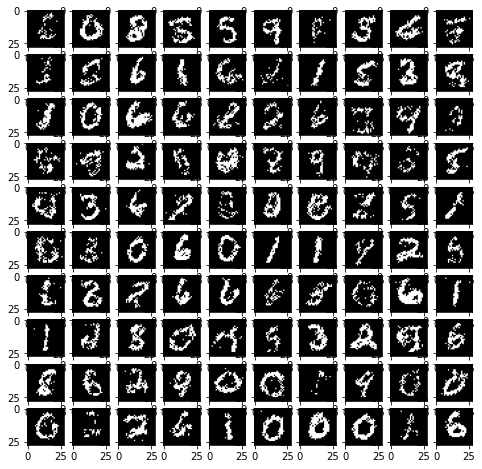

Epoch 71
test epoch loss: 99.403201
train epoch loss: 100.512076
Epoch 72
test epoch loss: 99.392615
train epoch loss: 100.354446
Epoch 73
test epoch loss: 99.374529
train epoch loss: 100.141200
Epoch 74
test epoch loss: 99.394257
train epoch loss: 99.823805
Epoch 75
test epoch loss: 99.380743
train epoch loss: 100.667750
Epoch 76
test epoch loss: 99.338399
train epoch loss: 100.402820
Epoch 77
test epoch loss: 99.329097
train epoch loss: 100.261351
Epoch 78
test epoch loss: 99.312437
train epoch loss: 100.067061
Epoch 79
test epoch loss: 99.330983
train epoch loss: 99.774201
Epoch 80
test epoch loss: 99.320061
train epoch loss: 100.556591


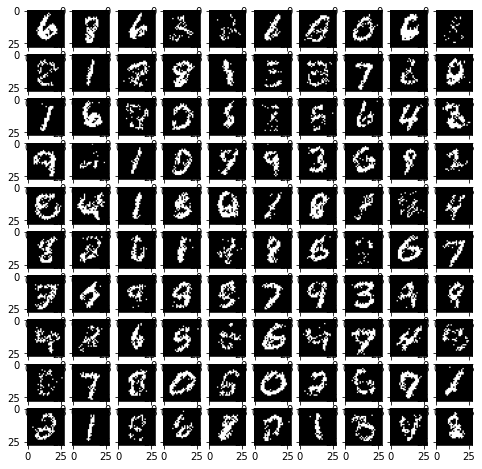

Epoch 81
test epoch loss: 99.278517
train epoch loss: 100.303366
Epoch 82
test epoch loss: 99.267479
train epoch loss: 100.175598
Epoch 83
test epoch loss: 99.253224
train epoch loss: 99.996132
Epoch 84
test epoch loss: 99.272568
train epoch loss: 99.722227
Epoch 85
test epoch loss: 99.262947
train epoch loss: 100.454437
Epoch 86
test epoch loss: 99.222073
train epoch loss: 100.210883
Epoch 87
test epoch loss: 99.211035
train epoch loss: 100.095394
Epoch 88
test epoch loss: 99.197552
train epoch loss: 99.927351
Epoch 89
test epoch loss: 99.215683
train epoch loss: 99.670153
Epoch 90
test epoch loss: 99.208098
train epoch loss: 100.298462


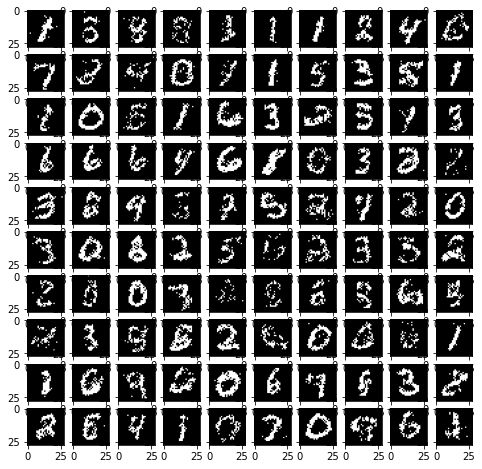

Epoch 91
test epoch loss: 99.121510
train epoch loss: 99.936614
Epoch 92
test epoch loss: 99.114671
train epoch loss: 99.730636
Epoch 93
test epoch loss: 99.112331
train epoch loss: 99.452716
Epoch 94
test epoch loss: 99.106079
train epoch loss: 99.063073
Epoch 95
test epoch loss: 99.110938
train epoch loss: 100.134128
Epoch 96
test epoch loss: 99.101953
train epoch loss: 99.857134
Epoch 97
test epoch loss: 99.097775
train epoch loss: 99.681530
Epoch 98
test epoch loss: 99.097881
train epoch loss: 99.429460
Epoch 99
test epoch loss: 99.092555
train epoch loss: 99.084917


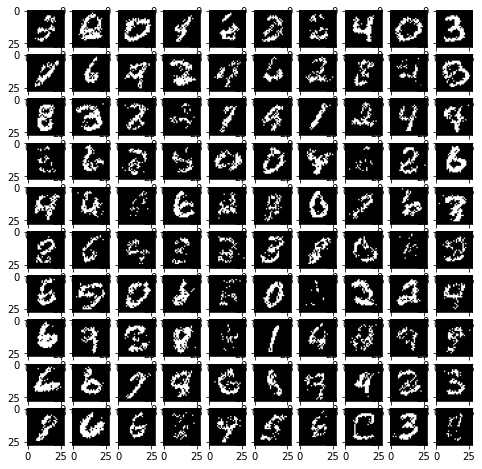

Training done


In [27]:
made.training(100, 100)

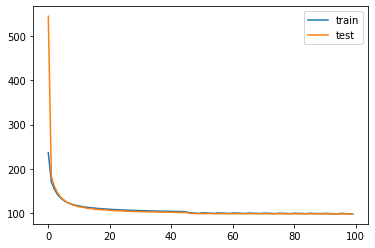

In [28]:
made.draw_epoch_loss()

In [29]:
def reconstructing(n, filename):
  before, after = made.reconstruct(n)
  fig = plt.figure(figsize = (10,10))
  columns = 2
  rows = n
  for i in range(0, rows, 1):
    fig.add_subplot(rows, columns, 2*i+1)
    plt.imshow(before[i].reshape(made.imgshape), cmap='gray')
    fig.add_subplot(rows, columns, 2*i+2)
    plt.imshow(after[i].reshape(made.imgshape), cmap='gray' )
  plt.savefig(filename)

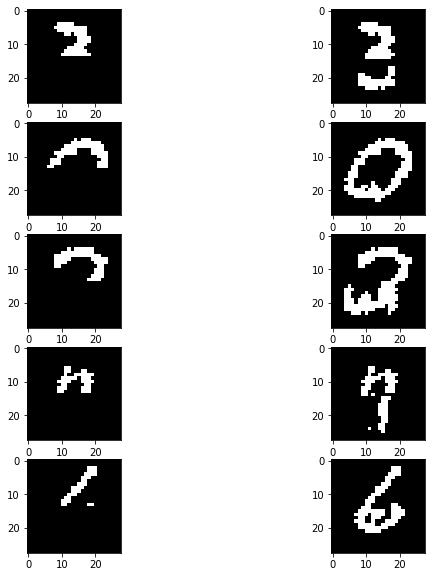

In [18]:
reconstructing(5, "/content/drive/My Drive/datasets/reconstructingx.png")